# Graph Neural Network with Karate Club

We will introduce how to build a neural network in this tutorial.

## Setup

In [404]:
!wget https://docs.dgl.ai/_downloads/1_first.ipynb

--2019-12-04 09:39:43--  https://docs.dgl.ai/_downloads/1_first.ipynb
Resolving docs.dgl.ai (docs.dgl.ai)... 54.191.249.50, 54.201.77.115
Connecting to docs.dgl.ai (docs.dgl.ai)|54.191.249.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14662 (14K) [application/octet-stream]
Saving to: ‘1_first.ipynb’

1_first.ipynb       100%[===================>]  14.32K  --.-KB/s    in 0s      

2019-12-04 09:39:43 (255 MB/s) - ‘1_first.ipynb’ saved [14662/14662]



In [177]:
%pylab inline
import networkx as nx
import scipy as sp
import torch as th
from matplotlib import colors

Populating the interactive namespace from numpy and matplotlib


## Load Data

Here we use the Zachary

Quote from wikipedia:
> A social network of a karate club was studied by Wayne W. Zachary for a period of three years from 1970 to 1972.[2] The network captures 34 members of a karate club, documenting links between pairs of members who interacted outside the club. During the study a conflict arose between the administrator "John A" and instructor "Mr. Hi" (pseudonyms), which led to the split of the club into two. Half of the members formed a new club around Mr. Hi; members from the other part found a new instructor or gave up karate. Based on collected data Zachary correctly assigned all but one member of the club to the groups they actually joined after the split.


In [178]:
edges=np.loadtxt("karate/edges.txt",dtype=np.int32)
nodes=np.loadtxt("karate/nodes.txt",dtype=np.int32)
nxg=nx.Graph()
for i in range(4):
    nxg.add_nodes_from(nodes[nodes[:,1]==i][:,0],labels=i)
nxg.add_edges_from(edges)

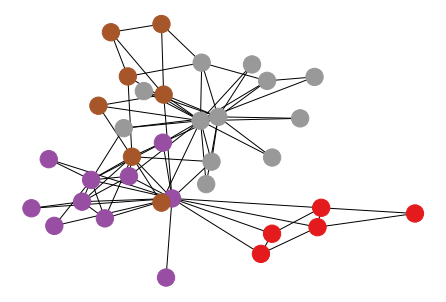

In [179]:
values= np.array([node[1]['labels'] for node in nxg.nodes(data=True)])
layout=nx.spring_layout(nxg)
nx.draw(nxg, pos=layout, cmap=plt.get_cmap('Set1'), node_color=values)

In [180]:
import dgl

In [181]:
g= dgl.DGLGraph()
g.from_networkx(nxg, node_attrs=['labels'])

In [350]:
num_nodes=g.number_of_nodes()
hidden_size = 34

In [351]:
g.ndata['feat'] = th.eye(num_nodes)

In [352]:
train_mask = th.zeros((num_nodes), dtype=th.bool)
train_mask[[0,2,4,8]] = 1

In [353]:
nxg = g.to_networkx(node_attrs=['labels']).to_undirected()

### Graph with masked labels

Red nodes's labels are masked out. Only 4 nodes' labels are visible during training process.

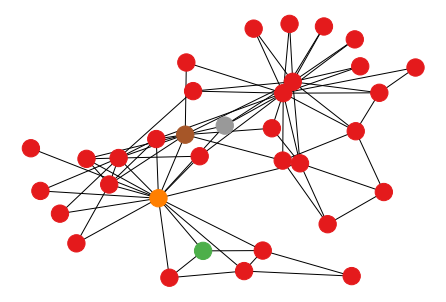

In [354]:
masked_values= -1*np.ones(num_nodes)
masked_values[[0,2,4,8]] = (g.ndata['labels'].numpy())[[0,2,4,8]]
layout=nx.spring_layout(nxg)
nx.draw(nxg, pos=layout, cmap=plt.get_cmap('Set1', 5), node_color=masked_values, vmin=-1, vmax=3)

### Graph with full labels

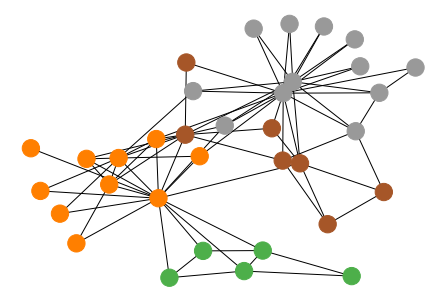

In [355]:
nx.draw(nxg,pos=layout, cmap=plt.get_cmap('Set1', 5), node_color=g.ndata['labels'].numpy(), vmin=-1, vmax=3)

## Model Setup

In [356]:
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import conv as dgl_conv

In [396]:
class GCNModel(nn.Module):
    def __init__(self):
        super(GCNModel, self).__init__()
        self.layers = nn.ModuleList([
            dgl_conv.GraphConv(in_feats=hidden_size, out_feats=64, activation=F.relu),
            dgl_conv.GraphConv(in_feats=64, out_feats=64, activation=F.relu),
            dgl_conv.GraphConv(in_feats=64, out_feats=4) # 4 is number of labels
#             dgl_conv.GraphConv(in_feats=64, out_feats=4) # 4 is number of labels
        ])
        
    def forward(self, g, features):
        h = features
        for layer in self.layers:
            h = layer(g, h)
        return h
        

In [397]:
model = GCNModel()
optimizer = th.optim.Adam(model.parameters())
loss_fcn = th.nn.CrossEntropyLoss()

In [398]:
epochs = 200

In [399]:
for e in range(epochs):
    logits = model(g, g.ndata['feat'])
    # Only backprop with 4 labeled nodes
    loss = loss_fcn(logits[train_mask], g.ndata['labels'][train_mask])
    train_acc = th.mean((th.argmax(logits, 1) == g.ndata['labels'])[train_mask].float())
    print(train_acc)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    

tensor(0.5000)
tensor(0.7500)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.7500)
tensor(0.7500)
tensor(0.7500)
tensor(0.7500)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tens

In [400]:
acc = th.mean((th.argmax(logits, 1) == g.ndata['labels']).float())

In [401]:
acc

tensor(0.5588)

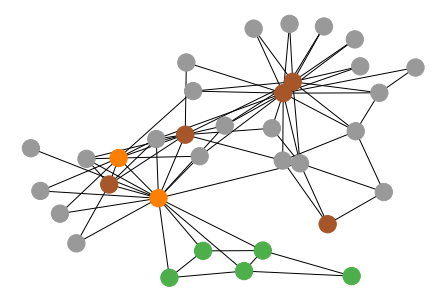

In [402]:
nx.draw(nxg,pos=layout, cmap=plt.get_cmap('Set1', 5), node_color=th.argmax(logits, 1), vmin=-1, vmax=3)